In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from seaborn import heatmap

/home/araminty/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Suppose we have some text we want to use in a machine learning model:  

Phrase 1: "I have a nice doggy.  Her name is Didi."  
Phrase 2: "I also have a naughty doggy.  His name is Innominate."  

Mathematical models dont generally take text as inputs so we need to turn these into numbers somehow.  This is called vectorizing.  It's a two part process.  

Step 1) Assign every word an ID  
Step 2) Use those words to make a vector (or some other mathematical format we can input into a model)

In [2]:
didi = "I have a nice doggy.  Her name is Didi."
nate = "I also have a naughty doggy.  His name is Innominate."

corpus = [didi, nate]
display(corpus)

['I have a nice doggy.  Her name is Didi.',
 'I also have a naughty doggy.  His name is Innominate.']

In [3]:
cvec = CountVectorizer()
cvec.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [4]:
vocab = cvec.vocabulary_
vocab

{'have': 3,
 'nice': 10,
 'doggy': 2,
 'her': 4,
 'name': 8,
 'is': 7,
 'didi': 1,
 'also': 0,
 'naughty': 9,
 'his': 5,
 'innominate': 6}

These can be used to 'translate' the sentence.

In [5]:
didi_words = didi.replace('.', '').split()
print('The list of words is:', didi_words)
didi_numbers = list(map(vocab.get, didi_words))
print('Which translate to:', didi_numbers)

The list of words is: ['I', 'have', 'a', 'nice', 'doggy', 'Her', 'name', 'is', 'Didi']
Which translate to: [None, 3, None, 10, 2, None, 8, 7, None]


There are two kinds of words it doens't handle:  
  1) Words we didn't make lowercase ("Didi"), easy fix  
  2) Words that are only 1 letter ("a"), which the default settings we are using discard

In [6]:
didi_words = didi.replace('.', '').lower().split()
print('The list of words is:', didi_words)
didi_numbers = list(map(vocab.get, didi_words))
print('Which translate to:', didi_numbers)

The list of words is: ['i', 'have', 'a', 'nice', 'doggy', 'her', 'name', 'is', 'didi']
Which translate to: [None, 3, None, 10, 2, 4, 8, 7, 1]


In the simplest models, called "bag of words" we can just take these labels by the presence or absence.

In [7]:
set(didi_numbers)

{1, 10, 2, 3, 4, 7, 8, None}

This simple approach is useful in spam filters.  For more complex language modeling like LSTM or Bert, we will preserve the position inforomation.  The sentence can be translated into a matrix showing

In [22]:
def words_to_dataframe(text, vocab):
    if type(text)==str:
        words = text.replace('.','').split()
    else:
        words = text
    
    numbers = list(map(vocab.get, map(str.lower, words)))
    matrix = pd.DataFrame([['0']*len(words)]*len(vocab))
    for index, (number, word) in enumerate(zip(numbers, words)):
        if number:
            matrix.iloc[number, index]=word
            
    # Making the sentence the column headers
    matrix.columns=words
    
    # Adding the words to the index:
    vocab_flip = { v:k for k, v in vocab.items()}
    index_labeler = lambda i: 'Key: ' + str(i) + ', Token: ' + str(vocab_flip.get(i))
    matrix.index = [ index_labeler(i) for i in range(len(vocab))]
    
    one_hot_encoded = matrix.apply(lambda x: [ 1 if i!='0' else 0 for i in x ])
    
    return matrix, one_hot_encoded

didi_dataframe, one_hot = words_to_dataframe(didi, vocab)
display(one_hot, one_hot.values)

I  have  a  nice  doggy  Her  name  is  Didi
Key: 0, Token: also        0     0  0     0      0    0     0   0     0
Key: 1, Token: didi        0     0  0     0      0    0     0   0     1
Key: 2, Token: doggy       0     0  0     0      1    0     0   0     0
Key: 3, Token: have        0     1  0     0      0    0     0   0     0
Key: 4, Token: her         0     0  0     0      0    1     0   0     0
Key: 5, Token: his         0     0  0     0      0    0     0   0     0
Key: 6, Token: innominate  0     0  0     0      0    0     0   0     0
Key: 7, Token: is          0     0  0     0      0    0     0   1     0
Key: 8, Token: name        0     0  0     0      0    0     1   0     0
Key: 9, Token: naughty     0     0  0     0      0    0     0   0     0
Key: 10, Token: nice       0     0  0     1      0    0     0   0     0

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0]])

This is a format that would make sense to use in a mathematical model.  It's no longer really human readable but we can graphically show how the information is contained in this matrix.

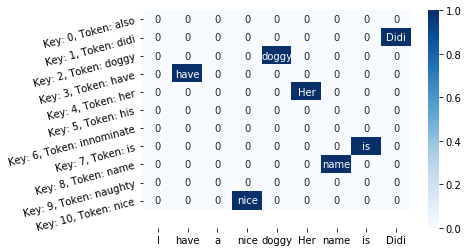

In [23]:
p = heatmap(one_hot.values, cmap='Blues', annot=didi_dataframe, fmt='')
p.set_ybound(lower=0, upper=12) # This is correcting a graphical regression in seaborn 3.1.1
p.set_xticklabels(didi_dataframe.columns)
p.set_yticklabels(didi_dataframe.index, rotation=15)
p

Now that we have defined a vocabulary on a corups we can try a new phrase

In [24]:
spot = cvec.transform(["My dog's name is Spot"])
spot

<1x11 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [25]:
spot.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

It's pretty limited.  We ran into a couple new problems.  
1) New vocabulary ("Spot")  
2) Different forms of words "dog's"

These result in far fewer labels then the training data

In [26]:
vocab_df = pd.DataFrame([(k, v) for v, k in vocab.items()])
vocab_df.columns=['id', 'word']
vocab_df = vocab_df.set_index('id').sort_index()
vocab_df['Spot Word Count'] = spot.toarray()[0]
vocab_df['Didi Frequency'] = cvec.transform([didi]).toarray()[0]
vocab_df['Nate Frequency'] = cvec.transform([nate]).toarray()[0]
print('Frequency for: "My dogs name is spot"\n' + didi + '\n' + nate)
display(vocab_df)

Frequency for: "My dogs name is spot"
I have a nice doggy.  Her name is Didi.
I also have a naughty doggy.  His name is Innominate.


word  Spot Word Count  Didi Frequency  Nate Frequency
id                                                             
0         also                0               0               1
1         didi                0               1               0
2        doggy                0               1               1
3         have                0               1               1
4          her                0               1               0
5          his                0               0               1
6   innominate                0               0               1
7           is                1               1               1
8         name                1               1               1
9      naughty                0               0               1
10        nice                0               1               0

The problem with other forms of words ("doggy" vs "dog's") can be addressed through stemming or lemmatization which will standardize words to their root of the word.

The problem with new vocab can be addressed by just gathering more data or basing your work off an existing dataset.  For example there are pretrained BERT models which are already "pre-trained" on the most common 30,000 words found on wikipedia pages for english.  If you use a package like Transformers which offers pre-trained models, you need to use the included tokenizer which has the tokens they used.